In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import timm  
import matplotlib.pyplot as plt

torch.manual_seed(1)

# Expanded set of hyperparameter configurations
configs = [
    {"learning_rate": 0.0001, "weight_decay": 1e-5, "scheduler_step": 10, "gamma": 0.5},
    {"learning_rate": 0.0003, "weight_decay": 1e-4, "scheduler_step": 15, "gamma": 0.3},
    {"learning_rate": 0.0005, "weight_decay": 5e-5, "scheduler_step": 5, "gamma": 0.7},
    {"learning_rate": 0.0002, "weight_decay": 1e-6, "scheduler_step": 8, "gamma": 0.6},
    {"learning_rate": 0.0004, "weight_decay": 1e-5, "scheduler_step": 12, "gamma": 0.4},
    {"learning_rate": 0.0001, "weight_decay": 5e-6, "scheduler_step": 10, "gamma": 0.8},
    {"learning_rate": 0.0003, "weight_decay": 2e-5, "scheduler_step": 6, "gamma": 0.5},
    {"learning_rate": 0.0002, "weight_decay": 1e-5, "scheduler_step": 5, "gamma": 0.7},
    {"learning_rate": 0.0005, "weight_decay": 1e-6, "scheduler_step": 10, "gamma": 0.6},
    {"learning_rate": 0.0001, "weight_decay": 1e-5, "scheduler_step": 15, "gamma": 0.4},
]

img_height, img_width = 48, 48
batch_size = 512
num_epochs = 40
patience, min_delta = 5, 0.01

# Data transformations with augmentation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((img_height, img_width)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
        transforms.RandomGrayscale(p=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'validation': transforms.Compose([
        transforms.Resize((img_height, img_width)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
}

# Load datasets
train_dataset = datasets.ImageFolder(root='/home/meilleur/Desktop/aps360/data/images/train', transform=data_transforms['train'])
val_dataset = datasets.ImageFolder(root='/home/meilleur/Desktop/aps360/data/images/validation', transform=data_transforms['validation'])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

results = []  # Store results for each config
best_val_loss = float('inf')
best_model_wts = None
best_config = None

for config in configs:
    # Initialize model
    model = timm.create_model('convnext_tiny', pretrained=True)
    model.head.fc = nn.Linear(model.head.fc.in_features, len(train_dataset.classes))
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=config["learning_rate"], weight_decay=config["weight_decay"])
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=config["scheduler_step"], gamma=config["gamma"])

    train_losses, val_losses, val_accuracies = [], [], []
    early_stop_count = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)

        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        train_loss /= len(train_loader.dataset)
        val_loss /= len(val_loader.dataset)
        val_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Early stopping
        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            best_model_wts = model.state_dict()
            best_config = config
            early_stop_count = 0
        else:
            early_stop_count += 1
            if early_stop_count >= patience:
                break

        scheduler.step()

    # Store results for current configuration
    results.append({
        "config": config,
        "train_losses": train_losses,
        "val_losses": val_losses,
        "val_accuracies": val_accuracies
    })

# Save the best model weights
if best_model_wts is not None:
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), 'best_model.pth')
    print("Best model saved with validation loss:", best_val_loss)
    print("Best hyperparameters:", best_config)
else:
    print("No improvement found across configurations.")

Best model saved with validation loss: 0.625179118997265
Best hyperparameters: {'learning_rate': 0.0001, 'weight_decay': 1e-05, 'scheduler_step': 10, 'gamma': 0.5}


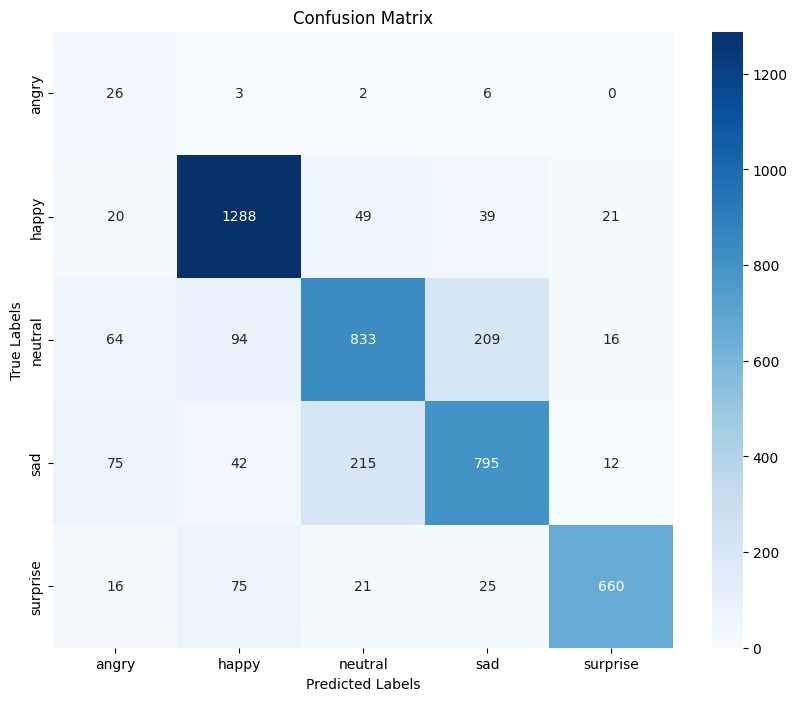

In [2]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Load the best model weights
model = timm.create_model('convnext_tiny', pretrained=False)  # Initialize the model structure
model.head.fc = nn.Linear(model.head.fc.in_features, len(train_dataset.classes))
model.load_state_dict(torch.load('best_model.pth'))
model = model.to(device)
model.eval()

# Get predictions and true labels for the validation set
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# Compute confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
class_names = val_dataset.classes  # Assuming the dataset has class names

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [5]:
from PIL import Image
import torch
import timm
import torchvision.transforms as transforms

# Define the inference function
def predict(image_path, model_path='best_model.pth', class_names=None, img_size=(48, 48), device=None):
    # Load the model architecture
    model = timm.create_model('convnext_tiny', pretrained=False)
    model.head.fc = nn.Linear(model.head.fc.in_features, len(class_names))
    model.load_state_dict(torch.load(model_path))
    model.eval()
    
    # Set device
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    # Define image preprocessing
    preprocess = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])

    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    image = preprocess(image).unsqueeze(0).to(device)

    # Make prediction
    with torch.no_grad():
        output = model(image)
        _, predicted_idx = torch.max(output, 1)
    
    # Get the predicted class label
    predicted_class = class_names[predicted_idx.item()] if class_names else predicted_idx.item()
    
    return predicted_class

# test the function
class_names = val_dataset.classes
image_path = '/home/meilleur/Desktop/aps360/data/images/validation/sad/70.jpg'
predicted_class = predict(image_path, 'best_model.pth', class_names)
print("Predicted class:", predicted_class)

Predicted class: sad
